# Kaggle 데이터를 이용한 자동차 가격 예측

### 데이터 확인 및 전처리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [240]:
car_df_org = pd.read_csv("C:/Users/pbyim/OneDrive/바탕 화면/시온/Data/car_price_prediction.csv")
car_df = car_df_org.copy()
car_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [8]:
car_df.shape

(19237, 18)

In [10]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [11]:
car_df.duplicated().sum()

313

- 중복 데이터는 삭제
- Mileage 피처가 있는 것으로 보아 중고차 가격 데이터인 것으로 보인다.
- 결측값은 없으나 levy피처에 '-'로 표시되어 있는 항목이 있다.

In [15]:
car_df['Levy'].value_counts()

Levy
-       5819
765      486
891      461
639      410
640      405
        ... 
3156       1
2908       1
1279       1
1719       1
1901       1
Name: count, Length: 559, dtype: int64

- '-'인 항목이 5819건으로 가장 많다.
- Levy는 (특히 세금의) 추가 부담금으로 '-'는 모두 0으로 바꿔 주어야 한다.
- 또한 현대 자료형이 object로 되어있으니 int로 변환해준다
-  Prod. year 피처도 날짜 자료형으로 변환해주겠다

- 다음으로 수치형 피처들의 분포를 살펴본다

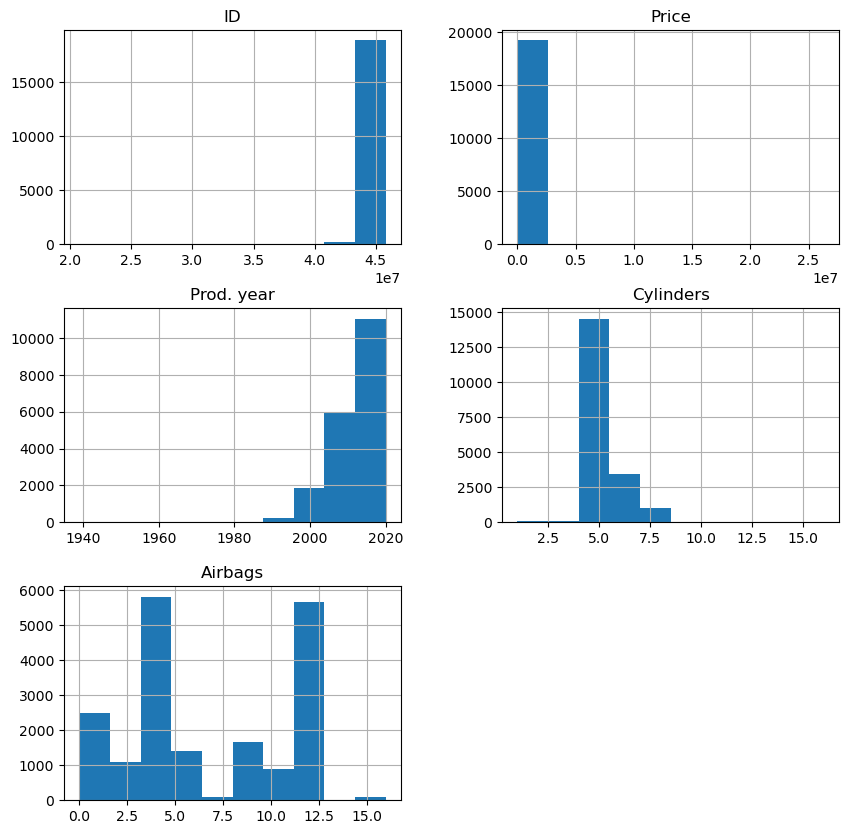

In [46]:
car_df.hist(figsize=(10,10), bins=10)
plt.show()

- ID는 회귀모델에서 불필요한 피처
- Target인 Price의 분포가 매우 극단적으로 치우쳐져 있는 것으로 보인다, describe 함수를 통해 수치로 파악해 보겠다

In [50]:
car_df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


- 확실히 Price의 값의 범위가 매우 극단적이다, 따라서 로그변환을 취해 다시 분포를 확인해본다

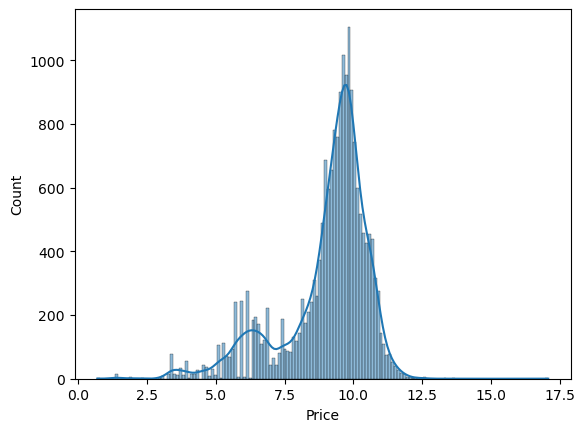

In [17]:
sns.histplot(np.log1p(car_df['Price']), kde=True)
plt.show()

- 변환하고 나니 원본에 비해 정규분포에 많이 가까워졌다, 모델링을 할 때는 변환된 자료를 사용한다
- 그 이유는 로그 변환은 큰 값의 영향을 상대적으로 줄여주어 이상치(outlier)가 모델에 미치는 영향을 감소시킬 수 있고
- 또한 선형 회귀와 같은 모델은 잔차(오차)가 정규분포를 따른다고 가정하기 때문에 로그 변환을 통해 분포를 대칭에 가깝게 만들어 잔차의 정규성을 개선할 수 있다.

- 다음으로 제조사와 모델의 종류를 확인한다

In [61]:
car_df['Manufacturer'].value_counts()

Manufacturer
HYUNDAI          3769
TOYOTA           3662
MERCEDES-BENZ    2076
FORD             1111
CHEVROLET        1069
                 ... 
TESLA               1
PONTIAC             1
SATURN              1
ASTON MARTIN        1
GREATWALL           1
Name: count, Length: 65, dtype: int64

In [63]:
car_df['Model'].value_counts()

Model
Prius                    1083
Sonata                   1079
Camry                     938
Elantra                   922
E 350                     542
                         ... 
Feroza                      1
C-MAX C-MAX                 1
X1 4X4                      1
Land Cruiser Prado RX       1
Prius C aqua                1
Name: count, Length: 1590, dtype: int64

- 총 65개의 제조사와 1590개의 모델이 있다
- 제조사별 모델 개수도 파악해본다

In [96]:
model_by_manu = car_df.groupby('Manufacturer')['Model'].count()
model_by_manu.sort_values()[:10]

Manufacturer
LAMBORGHINI     1
ASTON MARTIN    1
HAVAL           1
GREATWALL       1
TESLA           1
PONTIAC         1
LANCIA          1
SATURN          1
ZAZ             2
ROLLS-ROYCE     2
Name: Model, dtype: int64

- 하이엔드 또는 생소한 제조사의 모델 개수가 적은 것으로 보이며
- 현대, 도요타, 벤츠와 같은 대중적인 브랜드의 개수가 확실히 많다

In [85]:
model_counts = car_df['Model'].value_counts()
model_counts[model_counts.values < 3]

Model
Kicks                    2
Vitara GL+               2
Mariner                  2
Mark X                   2
B9 Tribeca               2
                        ..
Feroza                   1
C-MAX C-MAX              1
X1 4X4                   1
Land Cruiser Prado RX    1
Prius C aqua             1
Name: count, Length: 1124, dtype: int64

- 총 1590개의 모델 개수 중에 3대 이하인 모델이 1124종이 있다
- 이 많은 모델들을 인코딩하여 개별 레이블로 만드는 것이 바람직하다고 생각되지는 않으나 
- 추후 과정에서 Model 피처를 포함한 모델과 제외한 모델의 성능을 비교하고 결정하겠다
- 나머지 피처들을 계속해서 확인해본다

In [113]:
car_df['Doors'].value_counts()

Doors
04-May    18332
02-Mar      777
>5          128
Name: count, dtype: int64

In [117]:
car_df['Drive wheels'].value_counts()

Drive wheels
Front    12874
4x4       4058
Rear      2305
Name: count, dtype: int64

In [119]:
car_df['Gear box type'].value_counts()

Gear box type
Automatic    13514
Tiptronic     3102
Manual        1875
Variator       746
Name: count, dtype: int64

In [122]:
car_df['Wheel'].value_counts()

Wheel
Left wheel          17753
Right-hand drive     1484
Name: count, dtype: int64

In [195]:
car_df['Engine volume'].value_counts()

Engine volume
2            3916
2.5          2277
1.8          1760
1.6          1462
1.5          1321
             ... 
6.8             1
6.7             1
3.1             1
0.8 Turbo       1
1.1 Turbo       1
Name: count, Length: 107, dtype: int64

- Engine volume 또한 107개의 각기 다른 속성을 갖고 있다
- 하지만 일반 엔진과 Turbo엔진은 엄연히 다르기 때문에 섣불리 Turbo글자를 제거하기는 어렵다
- Model의 속성 개수에 비해서는 양호하기에 일단 그대로 사용하도록 하겠다
- 재활용을 위해 함수를 정의하겠다

In [242]:
def process_car_data(car_df_org):
    car_df = car_df_org.copy()
    car_df = car_df.drop_duplicates()
    car_df = car_df.drop('ID', axis = 1)
    car_df['Levy'].replace('-', 0, inplace=True)
    car_df['Levy'] = car_df['Levy'].apply(lambda x: int(x))
    car_df['Price'] = np.log1p(car_df['Price'])
    car_df['Mileage'] = car_df['Mileage'].str[:-3].apply(lambda x: int(x))

    return car_df

In [244]:
car_df = process_car_data(car_df_org)
car_df.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,9.497697,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,9.718482,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,9.044050,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,8.190909,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,9.369649,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [23]:
car_df.describe()

,Price,Levy,Prod. year,Mileage,Cylinders,Airbags
count,18924.000000,18924.000000,18924.000000,1.892400e+04,18924.000000,18924.000000
mean,9.028981,632.886493,2010.914236,1.555373e+06,4.580216,6.568379
std,1.585140,568.273736,5.665749,4.880221e+07,1.200223,4.322323
min,0.693147,0.000000,1939.000000,0.000000e+00,1.000000,0.000000
25%,8.581482,0.000000,2009.000000,7.019575e+04,4.000000,4.000000
50%,9.485925,642.000000,2012.000000,1.264000e+05,4.000000,6.000000
75%,10.001703,917.000000,2015.000000,1.891198e+05,4.000000,12.000000
max,17.085365,11714.000000,2020.000000,2.147484e+09,16.000000,16.000000


In [25]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18924 non-null  float64
 1   Levy              18924 non-null  int64  
 2   Manufacturer      18924 non-null  object 
 3   Model             18924 non-null  object 
 4   Prod. year        18924 non-null  int64  
 5   Category          18924 non-null  object 
 6   Leather interior  18924 non-null  object 
 7   Fuel type         18924 non-null  object 
 8   Engine volume     18924 non-null  object 
 9   Mileage           18924 non-null  int64  
 10  Cylinders         18924 non-null  float64
 11  Gear box type     18924 non-null  object 
 12  Drive wheels      18924 non-null  object 
 13  Doors             18924 non-null  object 
 14  Wheel             18924 non-null  object 
 15  Color             18924 non-null  object 
 16  Airbags           18924 non-null  int64  
dty

- 마지막으로 원핫 인코딩을 수행한다

In [246]:
car_df_encoded = pd.get_dummies(car_df, drop_first=True)
# Model피처를 제거한 데이터도 만들어 놓는다
car_df_reduced = car_df.drop('Model', axis=1)
car_df_encoded_reduced = pd.get_dummies(car_df_reduced, drop_first=True)

In [248]:
print(car_df_encoded.shape, car_df_encoded_reduced.shape)

(18924, 1805) (18924, 216)


- 피처의 개수가 9배정도 차이가 나는 것을 확인

# 선형모델 학습/예측/평가
- 우선은 선형 모델, 그 다음 트리 베이스 모델을 사용해 비교
- 평가 방법으로는 RMSE를 사용하겠다
- 학습이 완료되면 회귀 계수를 시각화하여 어떤 피처가 예측에 큰 영향을 주는지 확인해본다

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [16]:
def get_rmse(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    print(model.__class__.__name__, 'RMSE:', np.round(rmse,4))
    return np.round(rmse,4)

def get_model_rmses(models, X_test, y_test):
    rmses = []
    for model in models:
        rmse = get_rmse(model, X_test, y_test)
        rmses.append(rmse)
    return rmses

In [18]:
# 회귀계수 시각화 함수 
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index = X.columns)
    coef_top = coef.sort_values(ascending=False).head(n)
    coef_bottom = coef.sort_values(ascending=False).tail(n)
    return coef_top, coef_bottom

def visualize_coef(models, n=10):
    fig, axes = plt.subplots(figsize=(24,10), nrows=1, ncols=len(models))
    for i, model in enumerate(models):
        coef_top, coef_bottom = get_top_bottom_coef(model, n)
        coef = pd.concat([coef_top, coef_bottom])
        
        axes[i].set_title('Model:'+ model.__class__.__name__)
        axes[i].tick_params(axis='y', direction='in', pad=-120)
        sns.barplot(x=coef.values, y=coef.index, ax=axes[i])

- 우선은 Model피처를 포함한 데이터로 모델링

In [250]:
X = car_df_encoded.drop('Price', axis=1)
y = car_df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [252]:
lr_reg = LinearRegression()
lasso_reg = Lasso()
ridge_reg = Ridge()

lr_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)

linear_models = [lr_reg, lasso_reg, ridge_reg]
get_model_rmses(linear_models, X_test, y_test)

LinearRegression RMSE: 251.2777
Lasso RMSE: 1.5711
Ridge RMSE: 1.3305


[251.2777, 1.5711, 1.3305]

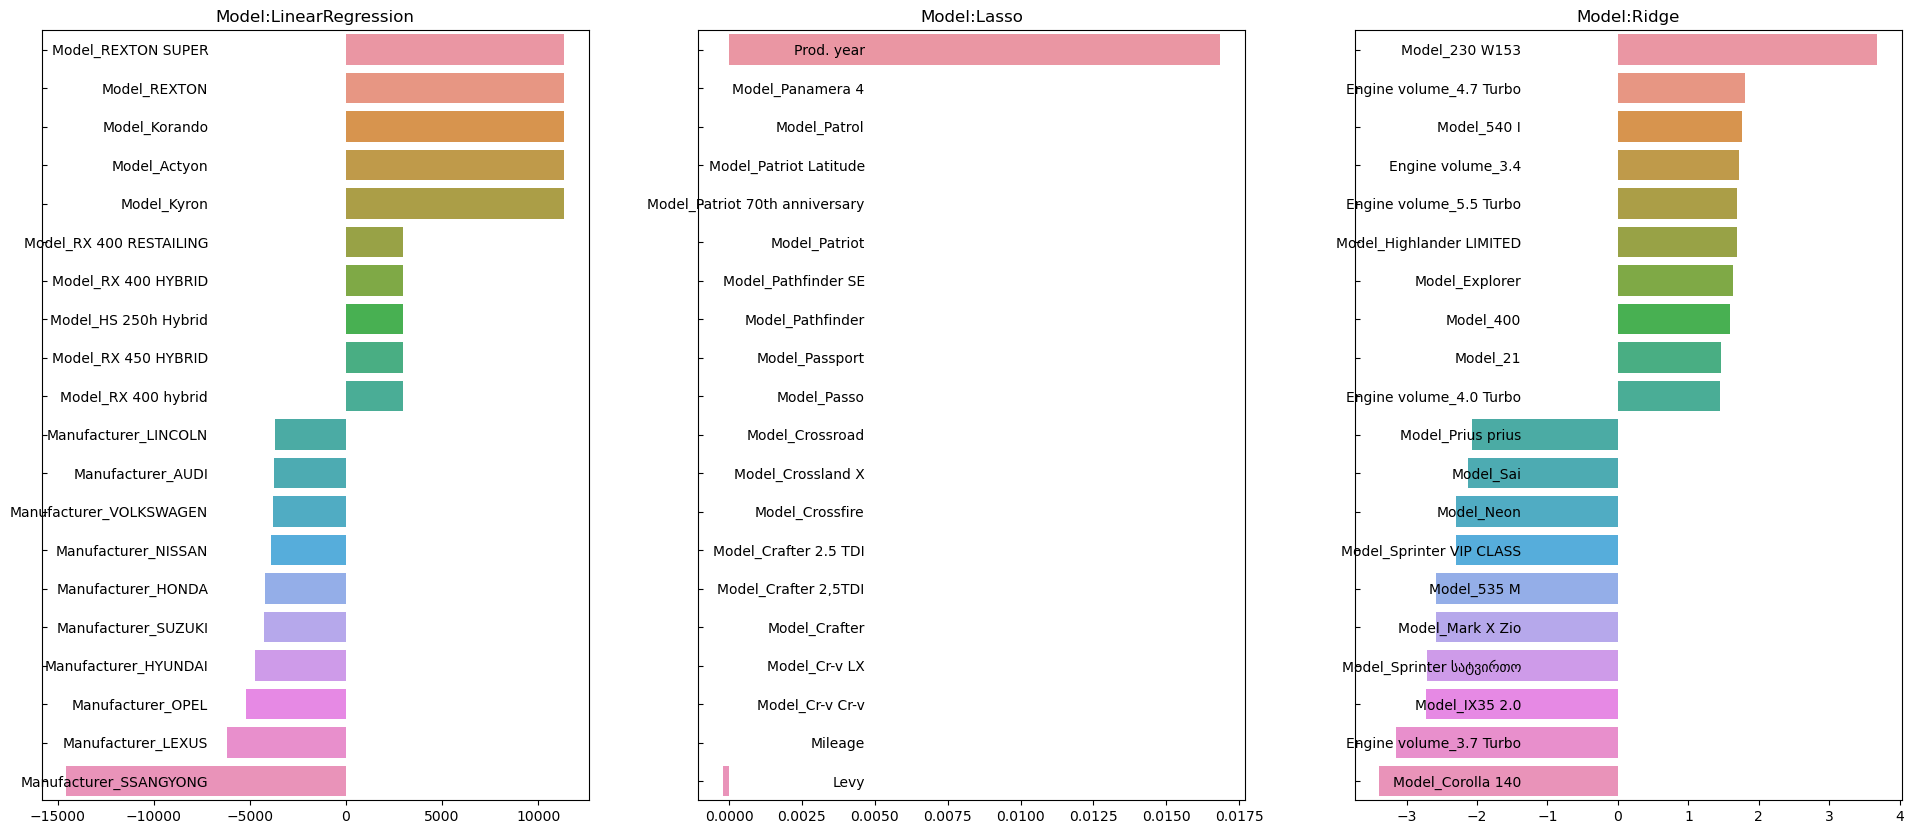

In [254]:
visualize_coef(linear_models)

- Model 피처를 제거한 데이터에 대해서도 학습/예측/평가 수행

In [260]:
X = car_df_encoded_reduced.drop('Price', axis=1)
y = car_df_encoded_reduced['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

lr_reg = LinearRegression()
lasso_reg = Lasso()
ridge_reg = Ridge()

lr_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)

linear_models = [lr_reg, lasso_reg, ridge_reg]
get_model_rmses(linear_models, X_test, y_test)

LinearRegression RMSE: 1.3861
Lasso RMSE: 1.5711
Ridge RMSE: 1.37


[1.3861, 1.5711, 1.37]

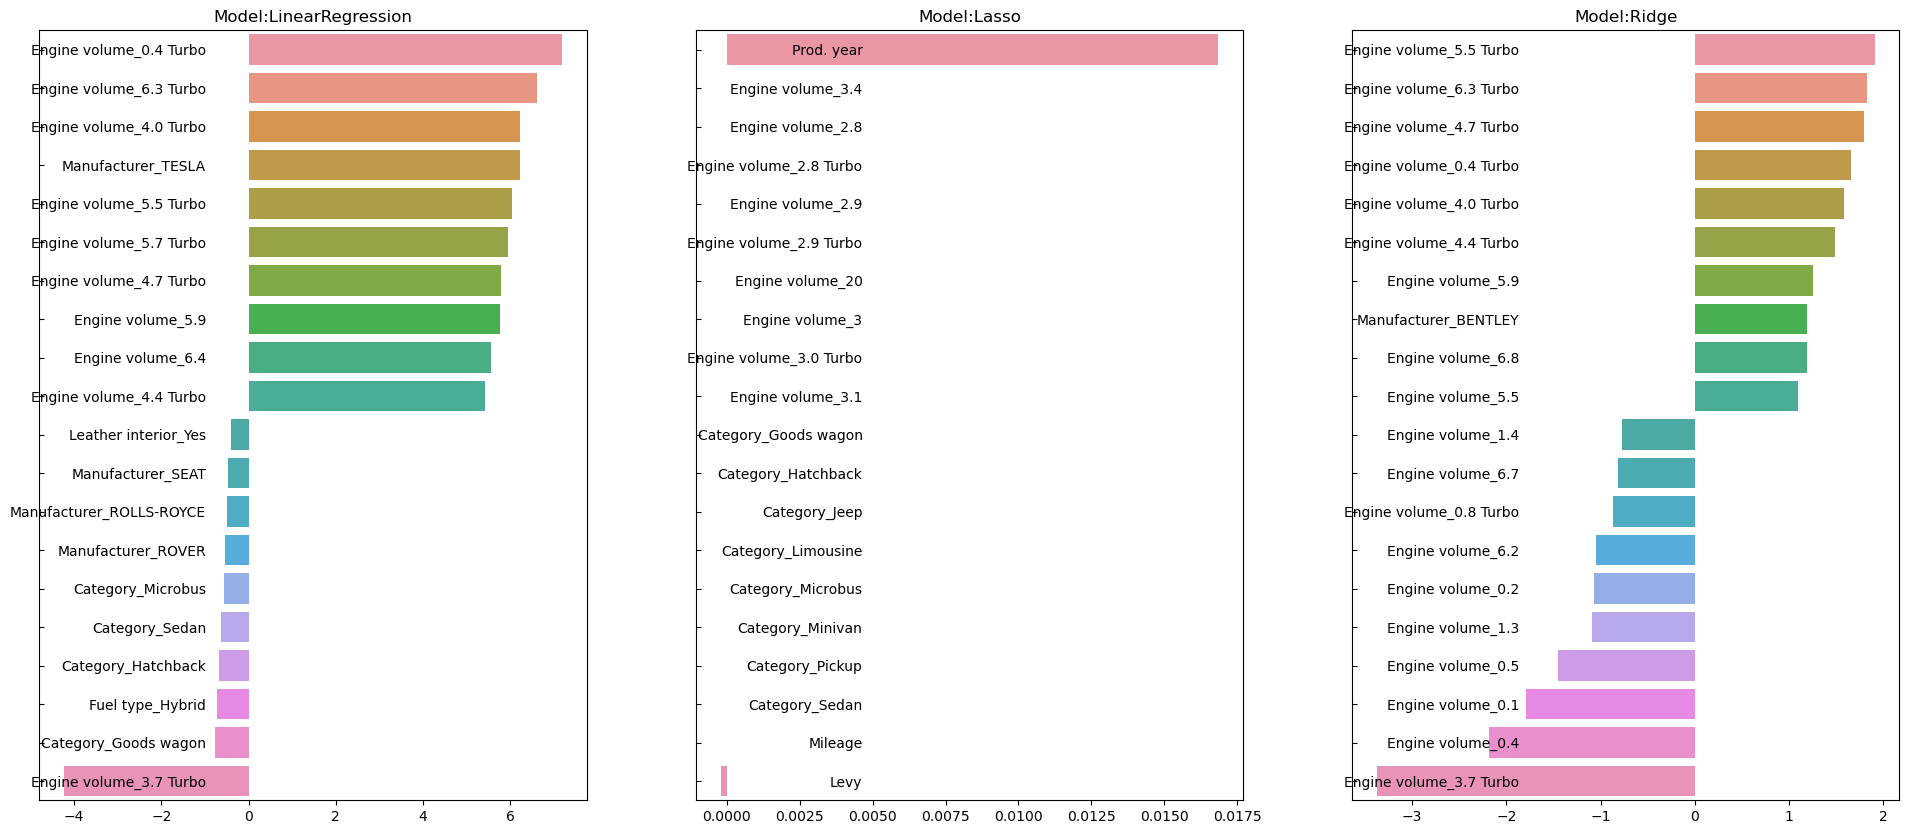

In [262]:
visualize_coef(linear_models)

- Model 피처를 포함한 모델의 성능이 미세하게 더 높으며 높은 회귀계수를 가진 피처는 Model과 Engine volume으로 확인된다
- 또한 Lasso 모델의 회귀계수 분포가 Prod. year과 Levy를 제외하고 보두 0이 되어버린 것이 확인 됐다
- Lasso 모델 특성상 회귀계수가 0이 나올 수는 있으나 현재는 피처에 대해 과도하게 규제가 되고 있는 것으로 보인다
- 따라서 cross_val_score로 데이터 분할 문제가 있는지 확인해 보겠다
- 데이터는 성능이 더 좋았던 Model피처를 포함한 데이터를 사용하겠다

In [22]:
from sklearn.model_selection import cross_val_score

In [24]:
def get_cv_rmses(models, X, y):
    for model in models:
        rmse_list = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5)
        rmse_avg = np.mean(rmse_list)
        print(f'Model: {model.__class__.__name__}')
        print(f'RMSE for each fold: {np.round(rmse_list, 3)}')
        print(f'Average RMSE {np.round(rmse_avg, 3)} \n')

In [264]:
X = car_df_encoded.drop('Price', axis=1)
y = car_df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

lr_reg = LinearRegression()
lasso_reg = Lasso()
ridge_reg = Ridge()

linear_models = [lr_reg, lasso_reg, ridge_reg]

In [266]:
get_cv_rmses(linear_models, X, y)

Model: LinearRegression
RMSE for each fold: [1.351000e+00 1.359000e+00 1.323000e+00 2.776826e+03 1.352000e+00]
Average RMSE 556.442 

Model: Lasso
RMSE for each fold: [1.567 1.571 1.563 1.589 1.565]
Average RMSE 1.571 

Model: Ridge
RMSE for each fold: [1.319 1.33  1.301 1.32  1.334]
Average RMSE 1.321 



In [63]:
# reduced 데이터에 대해서도 교차검증 수행
X = car_df_encoded_reduced.drop('Price', axis=1)
get_cv_rmses(linear_models, X, y)

Model: LinearRegression
RMSE for each fold: [1.374 1.382 1.353 1.368 1.384]
Average RMSE 1.372 

Model: Lasso
RMSE for each fold: [1.565 1.569 1.569 1.584 1.571]
Average RMSE 1.572 

Model: Ridge
RMSE for each fold: [1.363 1.37  1.349 1.367 1.383]
Average RMSE 1.366 



- 교차검증 수행 결과 Lasso 모델의 RMSE이가 계속 더 높기 때문에 데이터 분할 과정에서 문제가 있었던 것은 아닌 것 같다
- 문제는 일반 회귀모형의 RMSE가 이상하게 높은 경우가 있다는 것이다
- 이는 일반 회귀 모형은 규제 기능이 없어 피처가 매우 많은 현재 데이터에서 다중공선성 문제가 발생하기 때문으로 보인다
- 하지만 Lasso와 Ridge모델 모두 Model 피처를 포함했을 때 성능이 더 좋고
- 특히 Ridge모델은 일반 회귀모형에 비해 성능이 더 좋게 나타나고 있어 이 뒤로 일반 회귀모형은 사용하지 않겠다
- 다음으로 Ridge와 Lasso 모델에 대해 하이퍼 파라미터 튜닝을 통해 규제 강도를 조절해보겠다

In [269]:
X = car_df_encoded.drop('Price', axis=1)
y = car_df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [26]:
from sklearn.model_selection import GridSearchCV

In [28]:
def get_best_params(model, param_grid):
    grid_model = GridSearchCV(model, param_grid, scoring='neg_root_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = -1*grid_model.best_score_
    print(f'Model: {model.__class__.__name__}')
    print(f'RMSE: {rmse} Best parameter: {grid_model.best_params_} \n')
    best_param = grid_model.best_params_
    return best_param

In [49]:
# 넓은 범위 탐색을 위해 로그 스케일을 사용하여 매우 작은 값부터 매우 큰 값까지 탐색
ridge_params={'alpha': np.logspace(-4, 4, 50)}
lasso_params={'alpha': np.logspace(-4, 4, 50)}

ridge_reg = Ridge()
lasso_reg = Lasso()

ridge_alpha = get_best_params(ridge_reg, ridge_params)
lasso_alpha = get_best_params(lasso_reg, lasso_params)

Model: Ridge
RMSE: 1.3172175829538424 Best parameter: {'alpha': 3.727593720314938} 

Model: Lasso
RMSE: 1.3210172491014653 Best parameter: {'alpha': 0.00021209508879201905} 



- 본인 PC에서 약 15분 정도 소요되었으며 이렇게 구해진 파라미터를 사용해 모델링 수행

In [271]:
ridge_reg = Ridge(alpha=ridge_alpha['alpha'])
lasso_reg = Lasso(alpha=lasso_alpha['alpha'])

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)
    
linear_models = [ridge_reg, lasso_reg]
get_model_rmses(linear_models, X_test, y_test)

Ridge RMSE: 1.3266
Lasso RMSE: 1.333


[1.3266, 1.333]

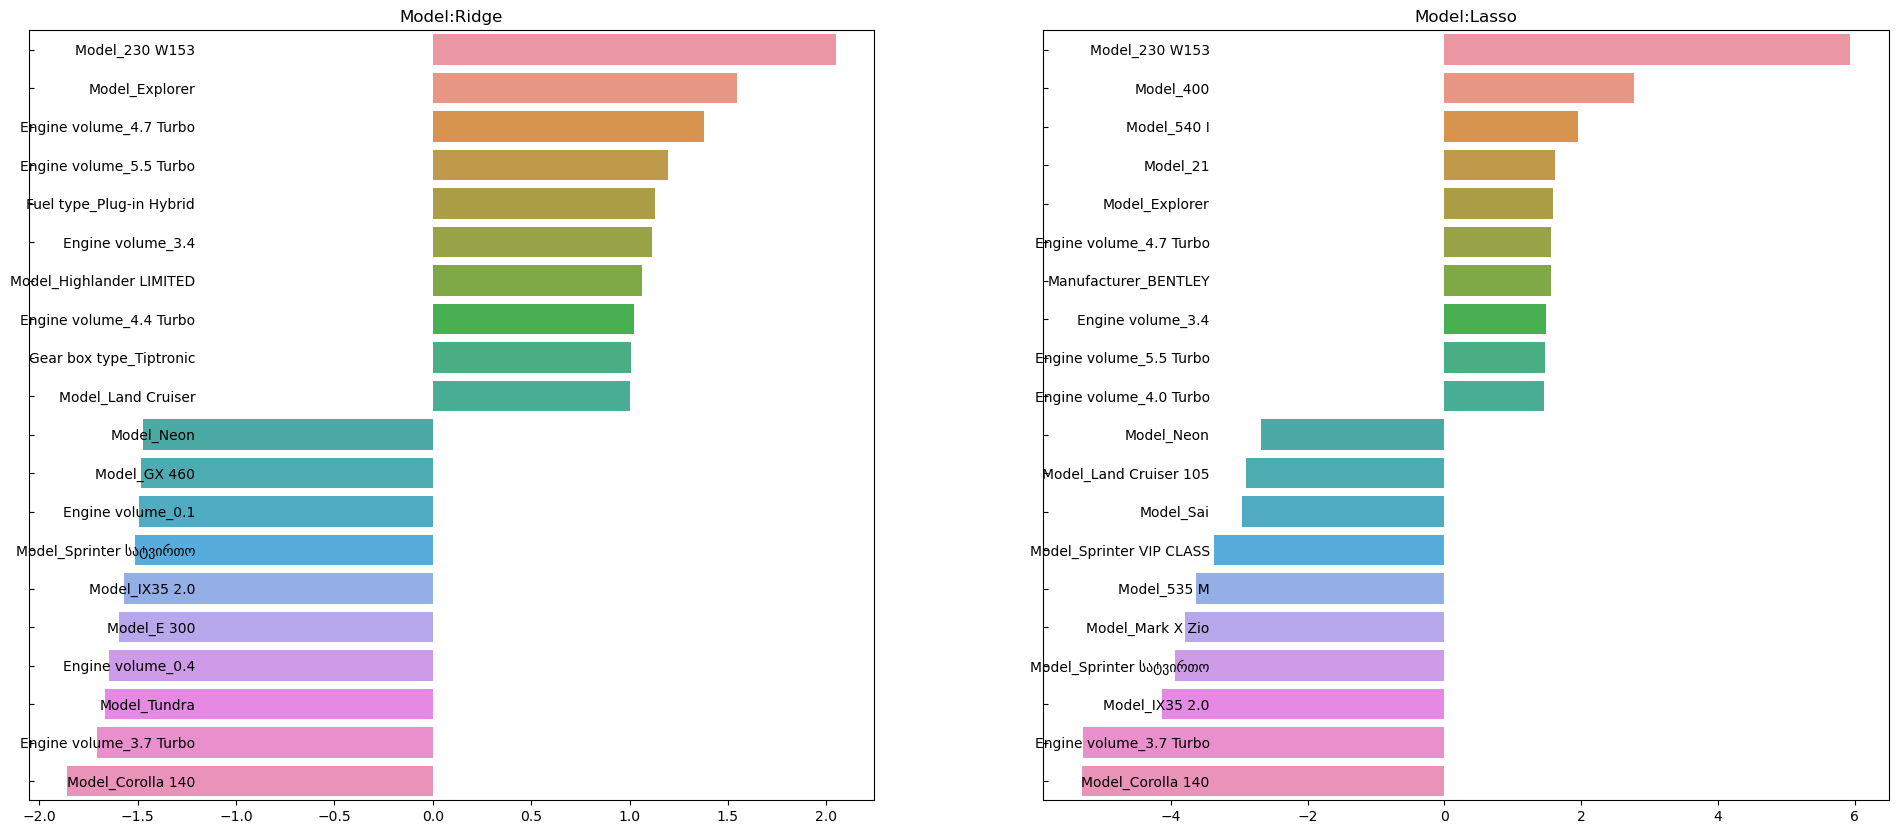

In [273]:
visualize_coef(linear_models)

- 두 모델의 성능이 모두 향상되었으며 Lasso 모델의 회귀계수 분포가 Ridge 모델과 유사해졌다
- 회귀계수를 확인해보면 중고차의 가격은 Model에 가장 큰 영향을 받고 그 다음으로 파워트레인, 즉 Engine volume에 가장 많은 영향을 받는다
- 사실 특정 모델들의 가격이 더 높을 수밖에 없는 것이 애초에 이런 차들은 신차가 자체가 높고 희소성과 브랜드 가치가 높다
- 따라서 중고차 시장에서도 가격이 더 높을 수밖에 없다
- 또한 예상했던 것 보다 Lasso모델의 최적 규제 강도가 많이 약해지며 Prod. year피처의 회귀계수가 많이 작아진 것으로 보이는데
- 중고차 가격이 연식의 영향을 안 받는 것은 상식적으로 불가능 하기에 추후에 이 부분을 다시 확인해보도록 하겠다
- 현재는 일단 Model이 가격에 가장 많은 영향을 미친다고 판단하고, 해당 피처를 제거했을 때 어떻게 바뀌는지 확인해본다

In [96]:
X = car_df_encoded_reduced.drop('Price', axis=1)
y = car_df_encoded_reduced['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [98]:
ridge_alpha = get_best_params(ridge_reg, ridge_params)
lasso_alpha = get_best_params(lasso_reg, lasso_params)

Model: Ridge
RMSE: 1.365077876207816 Best parameter: {'alpha': 5.428675439323859} 

Model: Lasso
RMSE: 1.3653951192071099 Best parameter: {'alpha': 0.00021209508879201905} 



In [102]:
ridge_reg = Ridge(alpha=ridge_alpha['alpha'])
lasso_reg = Lasso(alpha=lasso_alpha['alpha'])

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

linear_models = [ridge_reg, lasso_reg]
get_model_rmses(linear_models, X_test, y_test)

Ridge RMSE: 1.3475
Lasso RMSE: 1.3478


[1.3475, 1.3478]

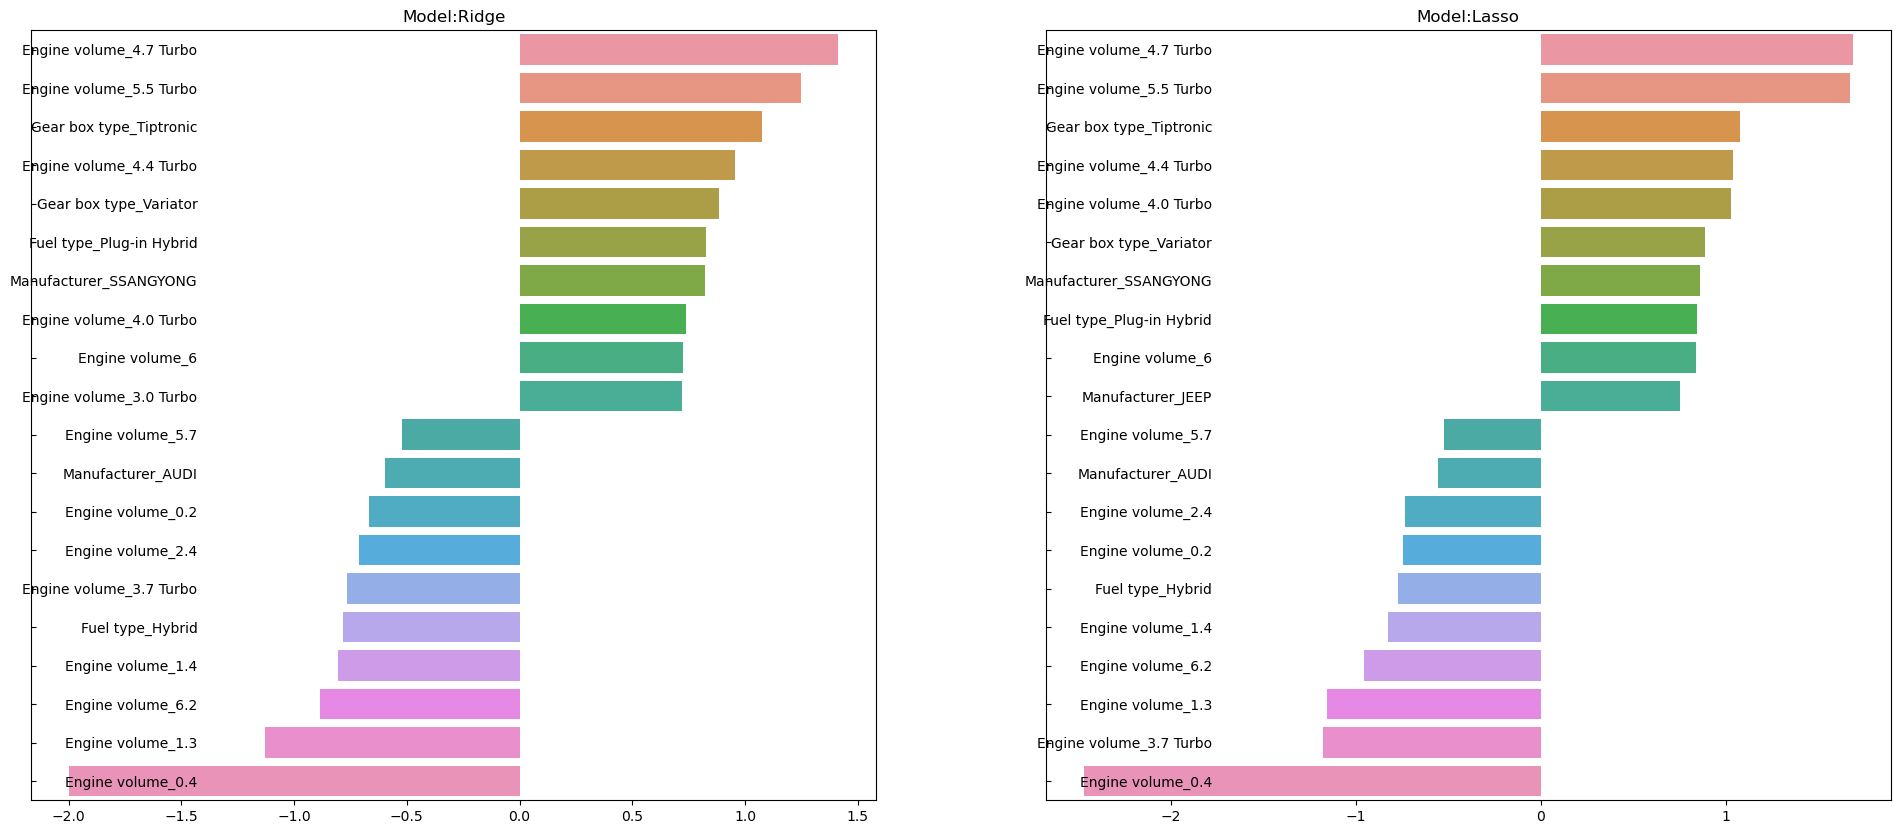

In [104]:
visualize_coef(linear_models)

- 이전에 봤듯이 Model을 제거하니 Engine Volume이 가격에 가장 많은 영향을 준다는 것을 알 수 있다.
- 그 다음으로 눈에 띄는 것은 Geaar box type(변속기)와 Fuel type이 있다.
    - (쌍용 자동차의 중고가가 높고 하이브리드 차량의 중고가가 낮은 것은 개인적으로 예상 외의 결과이다)
- 그런데 Model 피처를 제거하면 모델 성능이 떨어진다
- 이 문제를 해결하기 위해 특정 모델과 파워트레인의 등 요인으로 인해 가격이 이상하게 낮거나 높은 경우의 수를 제거한다
- 즉 이상치만 제거하고 모든 피처를 포함해서 다시 모델 학습/예측/평가를 수행해보겠다

In [275]:
def get_outlier_idx(df, column, weight=1.5):
    
    quantile25 = np.percentile(df[column].values, 25)
    quantile75 = np.percentile(df[column].values, 75)

    iqr = weight * (quantile75-quantile25)
    lower_bound = quantile25-iqr
    upper_bound = quantile75+iqr

    outlier_idx = df[(df[column]<lower_bound) | (df[column]>upper_bound)].index
    return outlier_idx

In [277]:
outlier_indices = get_outlier_idx(car_df, 'Price')
print(outlier_indices)

Index([    7,    15,    18,    26,    27,    33,    39,    44,    45,    53,
       ...
       19156, 19164, 19186, 19194, 19201, 19215, 19218, 19229, 19230, 19236],
      dtype='int64', length=2017)


- Price에서 이상치로 분류되는 자료가 무려 2017개나 있다

In [280]:
car_df = car_df.drop(outlier_indices, axis=0)
car_df_encoded = pd.get_dummies(car_df, drop_first=True)
car_df_encoded.shape

(16907, 1767)

In [282]:
X = car_df_encoded.drop('Price', axis=1)
y = car_df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [63]:
ridge_reg = Ridge()
lasso_reg = Lasso()

ridge_alpha = get_best_params(ridge_reg, ridge_params)
lasso_alpha = get_best_params(lasso_reg, lasso_params)

Model: Ridge
RMSE: 0.7606845489494892 Best parameter: {'alpha': 2.559547922699533} 

Model: Lasso
RMSE: 0.7622497744156244 Best parameter: {'alpha': 0.0001} 



In [284]:
ridge_reg = Ridge(alpha=ridge_alpha['alpha'])
lasso_reg = Lasso(alpha=lasso_alpha['alpha'])

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

linear_models = [ridge_reg, lasso_reg]
get_model_rmses(linear_models, X_test, y_test)

Ridge RMSE: 0.7689
Lasso RMSE: 0.7713


[0.7689, 0.7713]

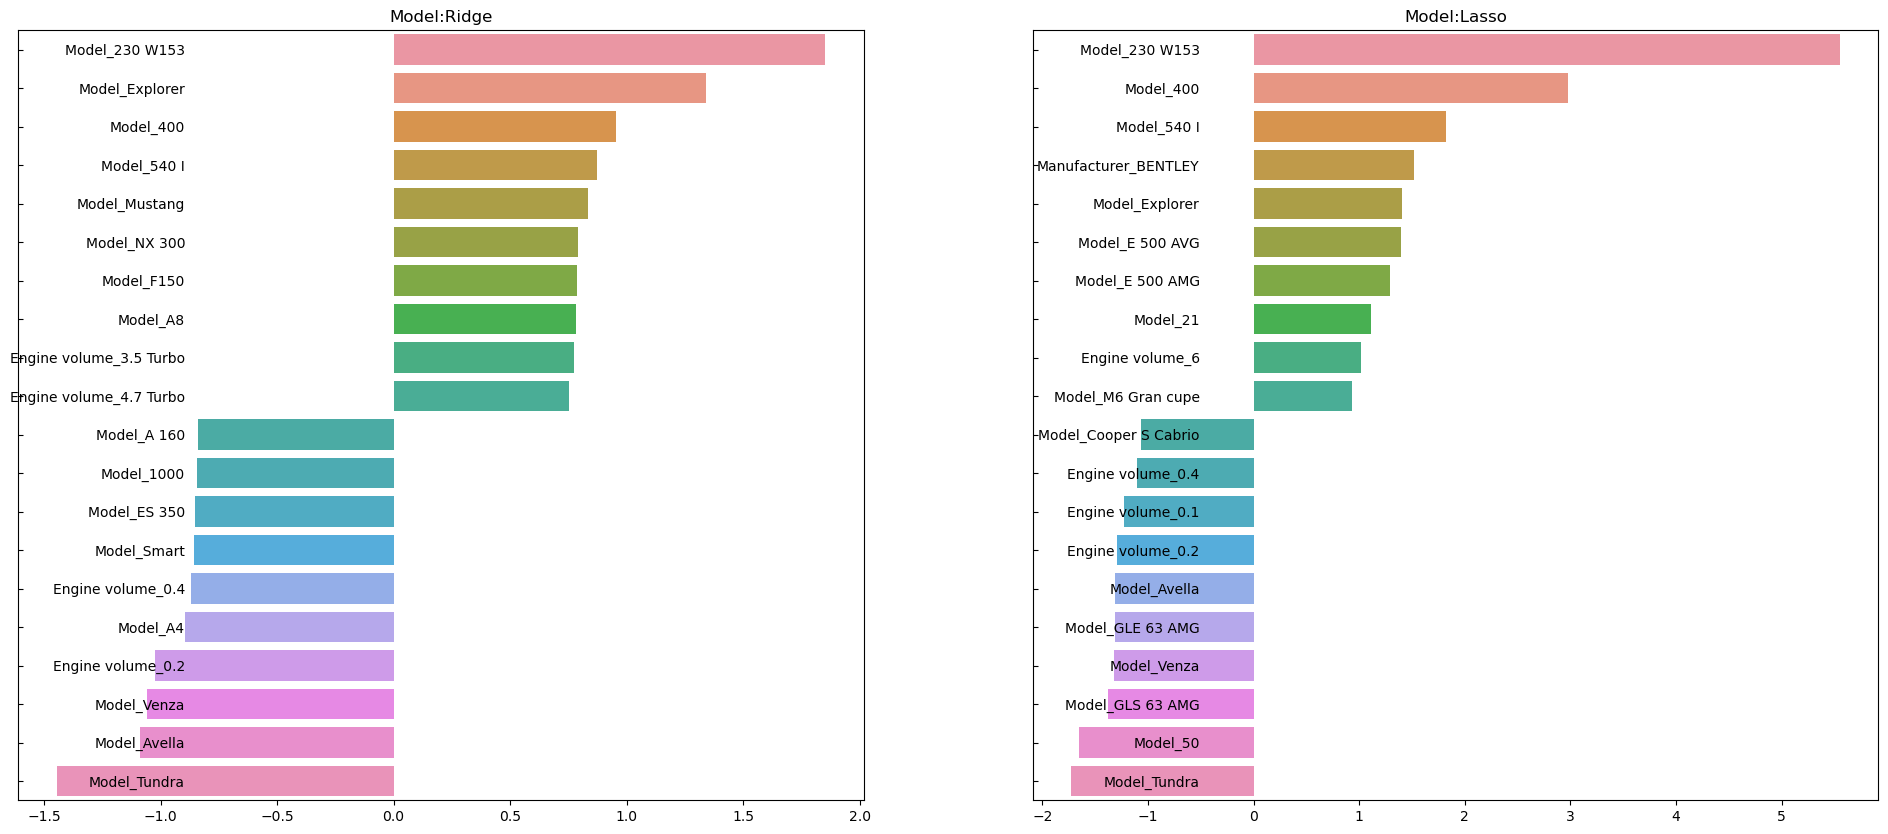

In [286]:
visualize_coef(linear_models)

- 이상치를 제거하자 모델 성능이 대폭 상승, 매우 효과적이였다
  - [1.3475, 1.3478] -> [0.7689, 0.7713]
- 다만 여전히 Model, Manufacturer과 Engine Volume이 회귀계수의 상,하위 10개를 모두 차지했다
- 선형 모델은 피처의 스케일의 영향을 많이 받기 때문에 스케일링을 한 후 다시 수행해본다
- 성능이 미세하게 계속 더 좋았던 Ridge모델을 사용하여 파이프라인을 만들어 학습을 수행하겠다.
- 또한 이상치 제거 과정을 데이터 전처리 함수에 추가하겠다

In [344]:
def process_car_data(car_df_org):
    car_df = car_df_org.copy()
    car_df = car_df.drop_duplicates()
    car_df = car_df.drop('ID', axis = 1)
    car_df['Levy'].replace('-', 0, inplace=True)
    car_df['Levy'] = car_df['Levy'].apply(lambda x: int(x))
    car_df['Price'] = np.log1p(car_df['Price'])
    car_df['Mileage'] = car_df['Mileage'].str[:-3].apply(lambda x: int(x))

    outlier_indices = get_outlier_idx(car_df, 'Price')
    car_df = car_df.drop(outlier_indices, axis=0)
    
    return car_df

In [289]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [293]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': np.logspace(-4, 4, 50)
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_['ridge__alpha'])

Best alpha: 1048.1131341546852


In [295]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(grid.best_params_['ridge__alpha']))
])

pipeline.fit(X_train, y_train)
get_rmse(pipeline, X_test, y_test)

Pipeline RMSE: 0.7747


0.7747

- 스케일링이 성능을 향상에 도움이 되지 않았다

- 지금 시점에서 1차적으로 결론을 내리면:
  - 중고차 가격은 다른 요인보다 어떤 모델이냐가 가장 큰 영향을 준다, 그 다음으로는 제조사와 파워트레인이 큰 영향을 준다
  - 이는 아무리 중고차라도 비싼 모델 또는 비싼 브랜드의 차량은 신차가가 높거나 희소성이 높기 때문에 가격이 높게 책정될 수밖에 없다
  - 그 다음으로 파워트레인은 자동차의 주행 성능에 직접적인 영향을 주는 요소이기 때문에 역시나 차량 가격에 큰 영향을 준다
  - 또한 일반적으로 가격이 비싼 차량에는 좋은 성능을 내는 파워트레인이 장착되는 경우가 많기 때문에 상호 연관성이 높다

- 다음으로는 회귀모델 자체의 성능을 최적화하기 위해 같은 데이터로 트리모델을 사용해 학습/예측/평가를 진행해 보겠다

# 트리모델 학습/예측/평가
- 평가 방법으로는 RMSE를 사용하겠다
- 학습이 완료되면 역시나 어떤 피처가 예측에 큰 영향을 주는지 확인해본다
- 다만 트리 모델은 회귀계수 기반이 아니기 때문에 feature_importances 속성을 시각화한다

In [41]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [29]:
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

tree_models = [rf_reg, xgb_reg, lgbm_reg]

ValueError: feature_names must be string, and may not contain [, ] or <

- XGBoost는 내부적으로 DMatrix를 사용하는데, feature_names가 숫자형이나 특수문자를 포함하여 위와 같은 에러가 발생했다

In [55]:
# 문제가 있는 피처 확인하는 함수
def check_columns(columns, disallowed):
    error = []
    for col in columns:
        if not isinstance(col, str):
            error.append((col, "not a string"))
        else:
            for char in disallowed:
                if char in col:
                    error.append((col, f"'{char}' included"))
    return error

In [36]:
error_cols = check_columns(X_train.columns, disallowed = ['[', ']', '<', '>'])
print(error_cols)

[('Model_Micra <DIESEL>', "'<' included"), ('Model_Micra <DIESEL>', "'>' included"), ('Doors_>5', "'>' included")]


In [48]:
# 허용되지 않은 특수문자를 변환 혹은 제거
X_train.columns = X_train.columns.str.replace('<', '_', regex=False)
X_train.columns = X_train.columns.str.replace('>', '', regex=False)
X_test.columns = X_test.columns.str.replace('<', '_', regex=False)
X_test.columns = X_test.columns.str.replace('<', '', regex=False)

error_cols = check_columns(X_train.columns, disallowed = ['[', ']', '<', '>'])
print(error_cols)

[]


In [50]:
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

tree_models = [rf_reg, xgb_reg, lgbm_reg]

LightGBMError: Do not support special JSON characters in feature name.

- 특수문자를 제거 했음에도 이번에는 LightGBM에서 에러가 발생
- 이는 LightGBM은 JSON 포맷의 제약 때문에 더 엄격하게 특수문자를 제한하기 때문

In [53]:
# 더 많은 특수문자를 포함하여 문제가 발생하는 feature_names 탐색
error_cols = check_columns(X_train.columns, disallowed = ['[', ']', '<', '>', '{','}','"'])
print(error_cols)

[('Model_FIT "S"- PAKETI.', '\'"\' included')]


In [59]:
X_train.columns = X_train.columns.str.replace('"', '', regex=False)
X_test.columns = X_test.columns.str.replace('"', '', regex=False)

error_cols = check_columns(X_train.columns, disallowed = ['[', ']', '<', '>'])
print(error_cols)

[]


In [61]:
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

LightGBMError: Do not support special JSON characters in feature name.

- 여전히 에러가 발생하여 가장 확실한 방법으로 정규 표현식을 사용하여 모든 feature name을 알파벳, 숫자, 언더스코어(_)만 포함하도록 재정의한다

In [43]:
import re

In [297]:
X.columns = X.columns.map(lambda x: re.sub('[^a-zA-Z0-9_]','_', str(x)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [71]:
rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

XGBoostError: [11:37:34] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\data\array_interface.h:218: Check failed: m == 1 || n == 1: 

- XGBoost에서 또 다른 에러가 발생했다
- Pandas DataFrame은 내부적으로 추가 메타데이터(인덱스, 컬럼명 등)를 포함하는 복잡한 array interface를 제공하는 반면, numpy 배열은 순수한 2차원 숫자 배열만 제공한다
- XGBoost는 DMatrix를 생성할 때 각 셀에 들어있는 값이 단일 스칼라여야 한다는 조건(즉, 각 셀의 array shape가 (1,) 또는 스칼라이어야 함)을 검사합니다. DataFrame의 경우, 일부 셀에 대한 array interface가 예상과 다르게 동작하거나 추가 메타정보 때문에 값의 shape가 불명확해질 수 있어, "Check failed: m == 1 || n == 1" 에러가 발생할 수 있다.
- 반면, X_train.to_numpy()를 사용하면 DataFrame이 순수한 2차원 numpy 배열로 변환되고, 각 셀에는 단일 스칼라 값만 남게 됩니다. 따라서 XGBoost의 DMatrix 생성 과정에서 요구하는 배열 형태가 명확해져 에러가 발생하지 않게 된다.

In [114]:
rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train.to_numpy(), y_train.to_numpy())
lgbm_reg.fit(X_train, y_train)

LightGBMError: Feature (Model_CT_200h_F_sport) appears more than one time.

- 그러나 또 다른 에러 발생, 중복열이 있는 것 같다
- 아무래도 이 전에 모든 특수문자를 _로 치환하면서 특정 열들의 이름이 같아진 것 같다

In [299]:
dup_cols = X.columns[X.columns.duplicated()].tolist()
print("중복된 컬럼:", dup_cols)

중복된 컬럼: ['Model_CT_200h_F_sport', 'Model_Prius________']


- 해당 열에 대해 중복열은 이름을 수정하여 처리

In [49]:
def process_duplicates(X, duplicated_col):
    """
    데이터프레임 X에서 특정 duplicated_col 이름을 가진 열이 여러 개 있을 경우,
    첫 번째 열은 그대로 두고 두 번째부터는 _2, _3, ... 형태로 이름을 변경합니다.
    
    Parameters:
        X (pd.DataFrame): 열 이름을 처리할 데이터프레임.
        duplicated_col (str): 중복되는 열 이름.
    
    Returns:
        pd.DataFrame: 변경된 열 이름을 가진 데이터프레임.
    """
    cols = X.columns.tolist()
    # duplicated_col과 동일한 열 이름의 인덱스 목록을 찾습니다.
    dup_idx = [i for i, col in enumerate(cols) if col == duplicated_col]
    
    # 만약 해당 열 이름이 두 개 이상 있으면, 첫 번째는 그대로 두고 나머지에 순번을 붙입니다.
    if len(dup_idx) > 1:
        for count, idx in enumerate(dup_idx[1:], start=2):
            cols[idx] = f"{duplicated_col}_{count}"
    
    X.columns = cols
    return X

In [301]:
X = process_duplicates(X, "Model_CT_200h_F_sport")
X = process_duplicates(X, "Model_Prius________")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [305]:
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
lgbm_reg = LGBMRegressor()

rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train.to_numpy(), y_train.to_numpy())
lgbm_reg.fit(X_train, y_train)

tree_models = [rf_reg, xgb_reg, lgbm_reg]
get_model_rmses(tree_models, X_test, y_test)

RandomForestRegressor RMSE: 0.4605
XGBRegressor RMSE: 0.5253
LGBMRegressor RMSE: 0.5095


[0.4605, 0.5253, 0.5095]

- 별도의 하이퍼파라미터 튜닝을 하지 않았음에도 선형모델에 비해 성능이 뛰어난 모습
- 혹시 feature_names를 추가적으로 처리하면서 뭔가 달라진 것이 있는지 확인하기 위해 선형 모델을 다시 한번 불러와 본다

In [308]:
ridge_reg = Ridge(alpha=ridge_alpha['alpha'])
lasso_reg = Lasso(alpha=lasso_alpha['alpha'])

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

linear_models = [ridge_reg, lasso_reg]
get_model_rmses(linear_models, X_test, y_test)

Ridge RMSE: 0.7689
Lasso RMSE: 0.7713


[0.7689, 0.7713]

- 이로써 현재 데이터에 대해서는 트리베이스 회귀모델의 예측성능이 더 뛰어나다고 결론지을 수 있겠다
- 이는 우리의 데이터가 상당히 많은 피처를 갖고 있어 복잡한 변수들 간의 관계를 선형적으로 정의하기 어렵기 때문으로 보인다
- 다음으로 feature_importances를 확인해 본다

In [310]:
def visualize_ftr_importances(models):
    fig, axes = plt.subplots(figsize=(10,6), ncols=len(models))
    for i, model in enumerate(models):
        ftr_imp = pd.Series(data=model.feature_importances_, index=X_train.columns)
        ftr_imp_top20 = ftr_imp.sort_values(ascending=False)[:20]
        
        axes[i].set_title(model.__class__.__name__)
        axes[i].tick_params(axis='y', pad=-120)
        sns.barplot(x=ftr_imp_top20.values, y=ftr_imp_top20.index, ax=axes[i])
    plt.tight_layout()
    plt.show()

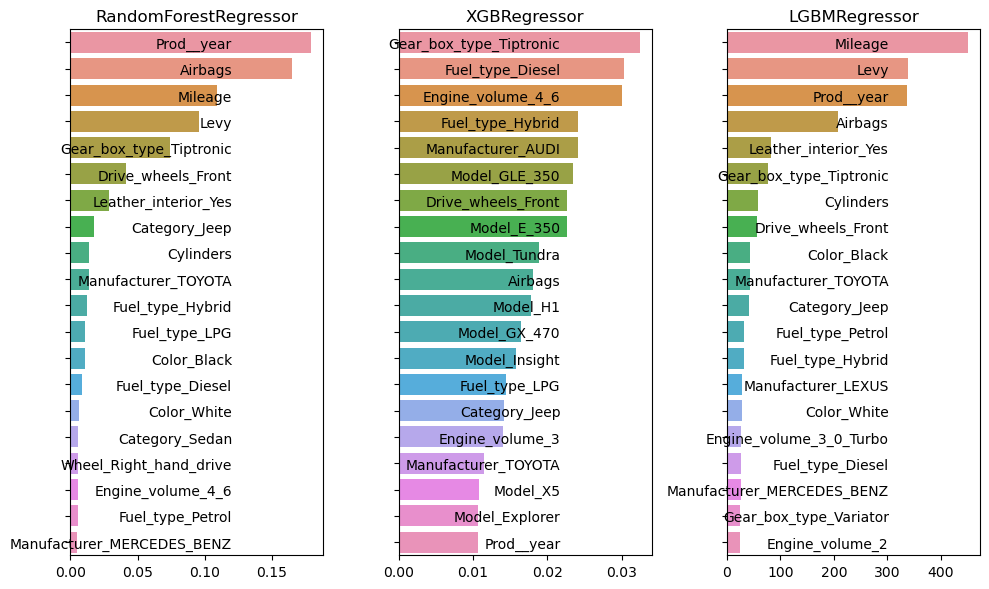

In [312]:
visualize_ftr_importances(tree_models)

- 선형 모델과는 상당히 다른 결과가 나왔다
- 이는 회귀 모델의 coef와 트리 모델의 feature_importances 두 속성 모두 피처의 상대적 영향력을 나타내긴 하지만
- 본질적으로는 다르게 계산되고 해석되기 때문이다.
- 회귀 모델의 coef (회귀 계수):
    - 선형 모델에서는 각 피처가 종속 변수에 미치는 선형적 영향의 크기와 방향(양수 또는 음수)을 나타낸다다.
    - 직접적인 해석이 가능하고, 한 단위의 변화가 종속 변수에 얼마나 영향을 미치는지 알 수 있다
- 트리 기반 모델의 feature_importances:
    - 트리 기반 모델에서는 각 피처가 모델 분할(스플릿)에 기여한 정도(예: 불순도 감소량)를 종합하여 중요도를 산출한다.
    - 방향성은 제공하지 않고, 단지 상대적인 중요도를 나타낸다

- 현재 3가지의 트리 모델의 feature_importances를 보면 XGBRegressor은 조금 다른 피처들에게 높은 중요도를 부여하고 있고
- RandomForest와 LightGBM 모델은 상위 중요도의 피처가 순서는 조금 다르지만 비슷한 피처를 선택하고 있다
- 우선 하이퍼파라미터 튜닝을 통해 모델 성능 개선을 노려보겠다

In [83]:
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

In [233]:
xgb_search_space = {
    'max_depth':hp.quniform('max_depth', 10, 20, 1),
    'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 0.8),
    'subsample':hp.uniform('subsample', 0.5, 0.8)
}

In [235]:
def xgb_obj_func(search_space):
    xgb_reg = XGBRegressor(n_estimators=200,
                           max_depth=int(search_space['max_depth']), 
                           learning_rate=search_space['learning_rate'], 
                           colsample_bytree=search_space['colsample_bytree'], 
                           subsample=search_space['subsample'])
    
    rmse = -1*cross_val_score(xgb_reg, X, y, scoring='neg_root_mean_squared_error', cv=5)
    
    return {'loss':np.mean(rmse), 'status': STATUS_OK}

In [237]:
trial_vals = Trials()

xgb_best = fmin(fn=xgb_obj_func, space=xgb_search_space, algo=tpe.suggest, max_evals=50, trials=trial_vals)
print(f'Best: {xgb_best}')

100%|█████████████████████████████████████████████| 50/50 [1:09:45<00:00, 83.71s/trial, best loss: 0.44205260208232466]
Best: {'colsample_bytree': 0.7996324945712481, 'learning_rate': 0.023892601321631506, 'max_depth': 20.0, 'subsample': 0.7947018288464734}


- LightGBM은 상대적으로 수행 속도가 빨라 넓은 범위 탐색

In [175]:
lgbm_search_space = {'max_depth':hp.quniform('max_depth',5,35,2),
                     'num_leaves':hp.quniform('num_leaves',50,200,1),
                     'subsample':hp.uniform('subsample',0.5,1),
                     'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))}

In [177]:
def lgbm_obj_func(search_space):
    lgbm_reg = LGBMRegressor(n_estimators=200,
                           max_depth=int(search_space['max_depth']), 
                           learning_rate=search_space['learning_rate'], 
                           num_leaves=int(search_space['num_leaves']), 
                           subsample=search_space['subsample'],
                           verbosity=-1)
    
    rmse = -1*cross_val_score(lgbm_reg, X, y, scoring='neg_root_mean_squared_error', cv=5)
    
    return {'loss':np.mean(rmse), 'status': STATUS_OK}

In [179]:
trial_vals = Trials()

lgbm_best = fmin(fn=lgbm_obj_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=50, trials=trial_vals)
print(f'Best: {lgbm_best}')

100%|████████████████████████████████████████████████| 50/50 [04:22<00:00,  5.26s/trial, best loss: 0.4636561281895445]
Best: {'learning_rate': 0.06470509339412155, 'max_depth': 34.0, 'num_leaves': 173.0, 'subsample': 0.58338080389023}


- 범위를 좁혀 재탐색

In [219]:
lgbm_search_space = {'max_depth':hp.quniform('max_depth',25,40,1),
                     'num_leaves':hp.quniform('num_leaves',100,200,1),
                     'subsample':hp.uniform('subsample',0.4,0.8),
                     'learning_rate':hp.loguniform('learning_rate', np.log(0.01), np.log(0.1))}

In [221]:
trial_vals = Trials()

lgbm_best = fmin(fn=lgbm_obj_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=50, trials=trial_vals)
print(f'Best: {lgbm_best}')

100%|███████████████████████████████████████████████| 50/50 [04:19<00:00,  5.19s/trial, best loss: 0.46448037674779086]
Best: {'learning_rate': 0.07488642496652761, 'max_depth': 36.0, 'num_leaves': 153.0, 'subsample': 0.5603040448099676}


- 구해진 하이퍼 파라미터로 모델 학습/예측/평가
- RandomForest 모델은 이미 성능이 우수했기에 n_estimators만 200개로 증가시켜 수행

In [314]:
rf_reg = RandomForestRegressor(n_estimators = 200)

In [316]:
xgb_reg = XGBRegressor(n_estimators = 200, 
                       max_depth=int(xgb_best['max_depth']), 
                       learning_rate=xgb_best['learning_rate'],
                       colsample_bytree=xgb_best['colsample_bytree'], )

In [318]:
lgbm_reg=LGBMRegressor(n_estimators=200, 
                    num_leaves=int(lgbm_best['num_leaves']),
                    max_depth=int(lgbm_best['max_depth']),
                    subsample=lgbm_best['subsample'],
                    learning_rate=lgbm_best['learning_rate'], verbosity=-1)

In [320]:
rf_reg.fit(X_train, y_train)
xgb_reg.fit(X_train.to_numpy(), y_train.to_numpy())
lgbm_reg.fit(X_train, y_train)

tree_models = [rf_reg, xgb_reg, lgbm_reg]
get_model_rmses(tree_models, X_test, y_test)

RandomForestRegressor RMSE: 0.4582
XGBRegressor RMSE: 0.4484
LGBMRegressor RMSE: 0.4574


[0.4582, 0.4484, 0.4574]

- 모든 모델의 성능이 향상, 특히 XGBooost와 LightGBM모델의 성능이 유의미하게 향상
  - [0.4605, 0.5253, 0.5095] -> [0.4582, 0.4484, 0.4574]
- 또한 XGBoost의 성능이 튜닝 전에는 가장 낮았으나 지금은 가장 높다

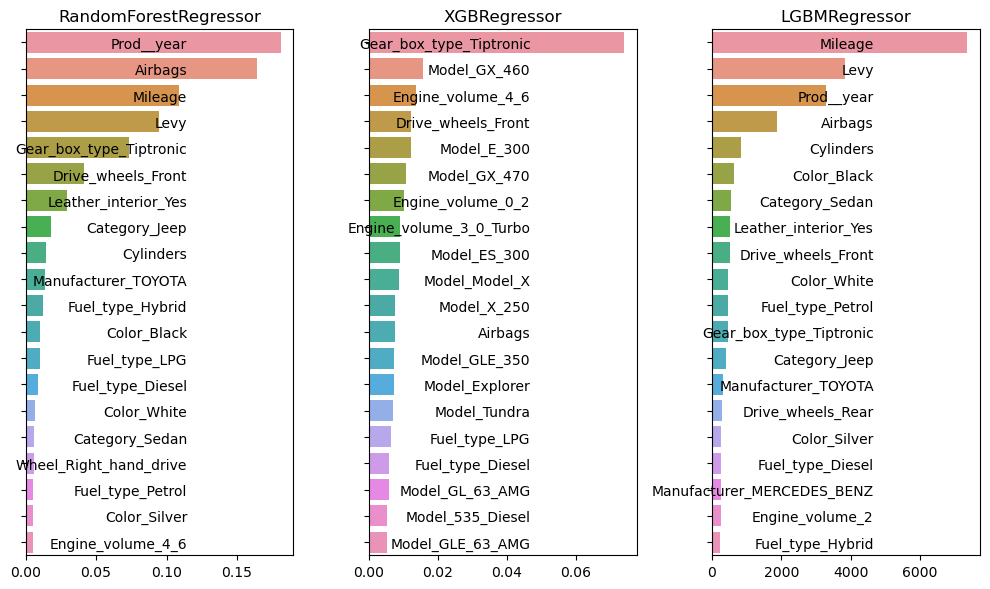

In [327]:
visualize_ftr_importances(tree_models)

### 최종 결과 해석

- **선형 모델 관점**:
  - 특정 차종(모델)이 가격 형성에 매우 큰 영향을 주는 것으로 나타남.
  - 그 다음으로는 배기량(Engine_volume)이 가격 결정에 중요한 역할을 할 수 있음.
  - 다만, 이는 “각 피처가 다른 변수와 독립적으로 가격에 미치는 **선형적인 영향**”을 가정한 결과.
- **트리 모델 관점**:
  - RandomForest와 LGBM 모델에 의하면 차량 연식(Prod_year), 주행 거리(Mileage), 세금(Levy), 에어백 개수(Airbags)가 가장 중요한 요인으로 작동.
  - 즉 “어떤 차종인지”보다는, “얼마나 오래되고 얼마나 많이 달렸는지”가 중고차 가격 변동에 큰 영향을 미친다는 결과.
  - 반면 XGB 모델은 여전히 차종과 배기량을 중요한 변수로 판단하고 있음. 특이한 점은 Tiptronic변속기를 가장 중요한 변수로 선택.
  - 팁트로닉은 '운전자가 자동 변속기에서 수동으로 기어를 선택할 수 있는 기술'로
  - 주로 스포츠카와 고성능 차량에서 흔히 볼 수 있다 (최근에는 일반적인 상용차에도 많이 탑재가 되는 것으로 알고 있다)

- 해당 결과를 기반으로 더욱 정확한 결과 해석을 위해 모델 성능과 상관없이 Model과 Engine Volume 피처를 모두 제외했을 때 회귀계수의 분포를 추가적으로 확인해본다
- 추가적으로 Manufaturer(제조사)도 차종과 상관 관계가 크기 때문에 제거

In [368]:
car_df = process_car_data(car_df_org)
print(car_df.shape)
car_df.head(2)

(16907, 17)


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,9.497697,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,9.718482,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


In [370]:
car_df.drop(['Model', 'Engine volume', 'Manufacturer'], axis=1, inplace=True)
car_df_encoded = pd.get_dummies(car_df, drop_first=True)

X = car_df_encoded.drop('Price', axis=1)
y = car_df_encoded['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [372]:
ridge_reg = Ridge()
lasso_reg = Lasso()

ridge_alpha = get_best_params(ridge_reg, ridge_params)
lasso_alpha = get_best_params(lasso_reg, lasso_params)

Model: Ridge
RMSE: 0.8440718652120214 Best parameter: {'alpha': 1.7575106248547894} 

Model: Lasso
RMSE: 0.8440546559002348 Best parameter: {'alpha': 0.0001} 



In [374]:
ridge_reg = Ridge(alpha=ridge_alpha['alpha'])
lasso_reg = Lasso(alpha=lasso_alpha['alpha'])

ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

linear_models = [ridge_reg, lasso_reg]
get_model_rmses(linear_models, X_test, y_test)

Ridge RMSE: 0.8418
Lasso RMSE: 0.8419


[0.8418, 0.8419]

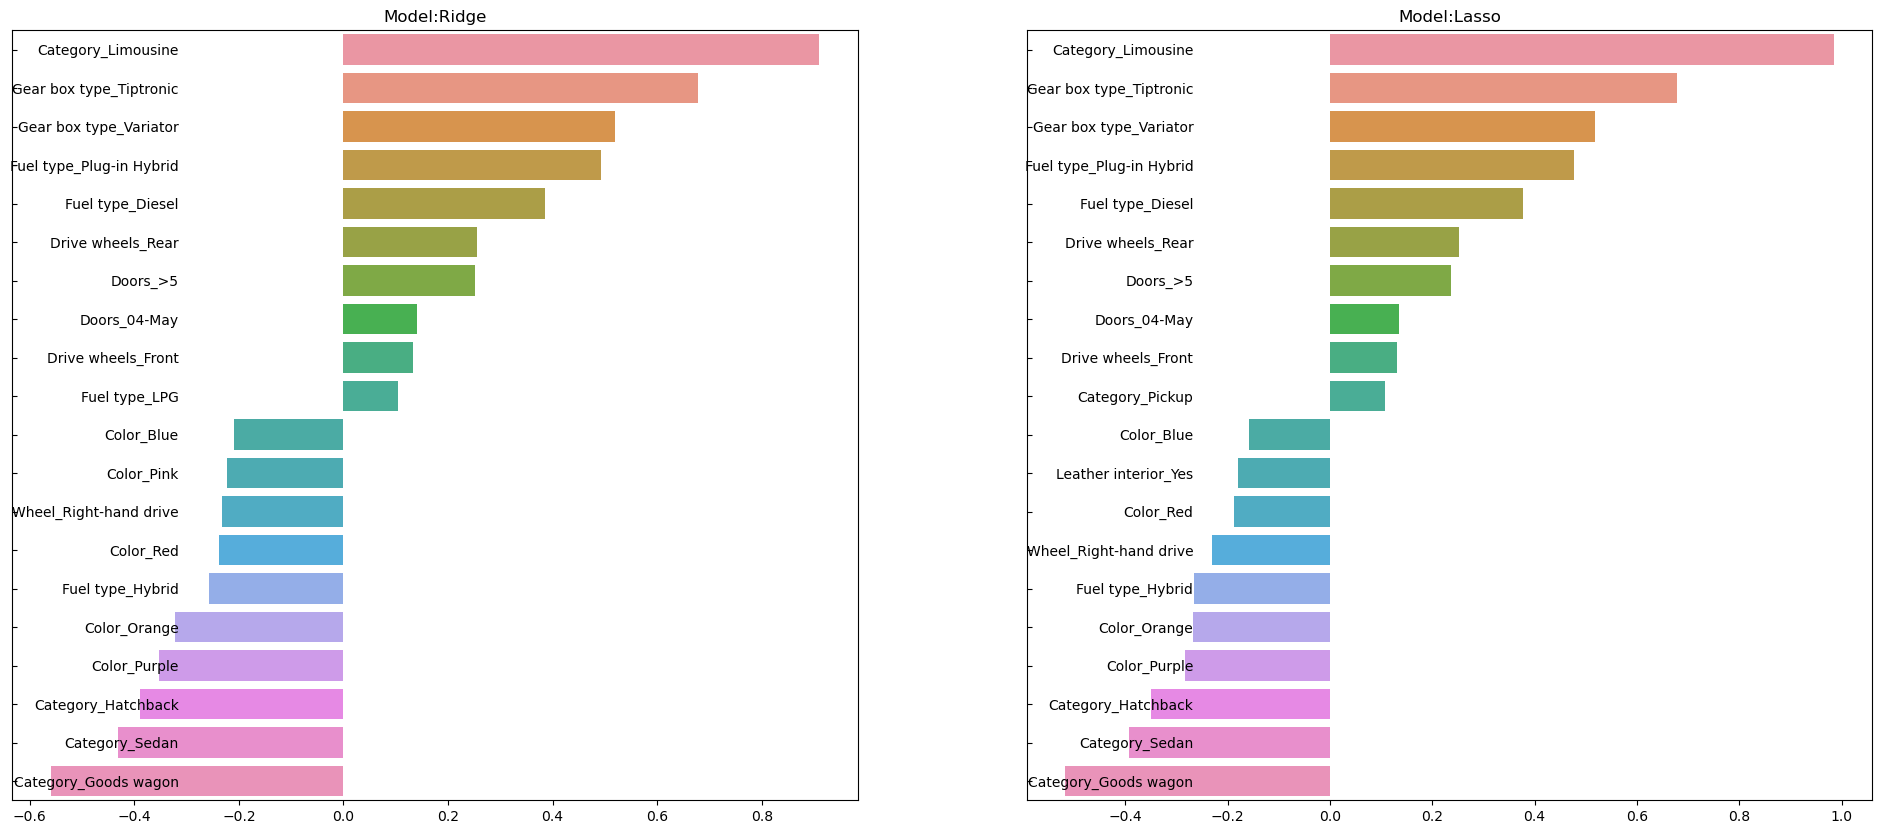

In [376]:
visualize_coef(linear_models)

- 피처들을 제거하자 두 모델의 회귀계수 분포가 거의 동일해졌다, 예측 성능은 다소 감소했지만 현재의 목적은 모델 성능 개선이 아니니 신경쓰지 않겠다

- 결과를 보면 차량 카테고리가 차량 가격에 가장 큰 영향을 준다.
- 그 외에는 앞서 XGB모델이 나타낸 것과 같이 팁트로닉 변속기와 Variator 변속기가 탑재된 차량의 가격이 높다.
- 하지만 음의 회귀계수를 보면 이외의 변속기는 가격에 큰 영향을 미치지는 않는 것으로 보인다.
- 또한 연료 종류가 차량 가격에(+/-) 영향을 준다
- 색상은 일반적으로는 크게 상관 없지만 특이한 색상은 차량 가격을 낮추는 것으로 보인다
- 다만 여전히 앞서 트리 모델이 중요하게 선택한 연식, 주행거리는 높은 회귀계수를 할당받지 못했다

#### 결론을 내리자면
- 기본적으로는 브랜드와 차종이 차량 가격에 가장 큰 영향을 준다.
- 이는 럭셔리 브랜드의 고가 차종은 높은 신차가와 희소성으로 인해 중고가 또한 높기 때문이다.
- 다만 피처들관의 상관관계와 비선형적인 관계를 종합적으로 고려했을 때는 연식과 주행거리, 연료 타입이 가장 차량 중고가에 큰 영행을 준다

- 여기서 에어백 개수, 특정 변속기를 주요 변수로 고려하지 않는 이유는 일반적으로 고가 브랜드, 고가/고성능 차종에 더 많은 에어백과 더 좋은 성능의 특정 변속기가 들어가기 때문이다.
- 따라서 사실 이런 관점에서 보면 결국 동일한 조건 이라면 연식, 주행거리, 연료 타입이 가장 영향이 크다고 결론을 내릴 수 있겠다,